In [118]:
import CCD_packages
import numpy as np
from nilearn import image
from pandas import read_csv
from tqdm import tnrange, tqdm_notebook
from time import sleep

GroupDF,motionInfo=CCD_packages.getCCDSubjectData(saveMotionInfo=False)
goodsubj,badsubj = CCD_packages.getSubjectList(GroupDF=GroupDF,motionThresh=1,poor_performer=14)

zmap_filenames=[]
fc='R_AI'
secondlevel_folder_names=['noFeedback','Feedback','train']
fb=1
behavioral_target=np.arctanh(np.array(GroupDF[np.all([GroupDF.Subject_ID.isin(goodsubj),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID')['modelcorr'].mean()))
cope=0
RSN=0
for subj in goodsubj:
    fbLoc=CCD_packages.fb_subjectinfo(subj,fb)
    if RSN>0:
        fname= '/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/%s_data_/dr_tempreg_maps_files_to_standard_smooth/_scan_feedback_%d/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf1/_spatial_map_PNAS_Smith09_rsn10/_fwhm_6/_dr_tempreg_maps_files_smooth_0%d/temp_reg_map_000%d_antswarp_maths.nii.gz' % (subj,fbLoc+1,RSN,RSN)
    elif len(fc)>0:
        fname= '/home/jmuraskin/Projects/CCD/working_v1/seed-to-voxel/%s/%s/%s_%s.nii.gz' % (fc,secondlevel_folder_names[fb],fc,subj)
    else:
        fname = '/home/jmuraskin/Projects/CCD/working_v1/feedback_run-%d/feedback/_subject_id_%s/modelestimate/mapflow/_modelestimate0/results/%s%d.nii.gz' % (fbLoc,subj,'cope',cope)

    zmap_filenames.append(fname)

mask_filename='/home/jmuraskin/Projects/CCD/working_v1/seg_probabilities/grey_matter_mask-20-percent.nii.gz'

No DR .txt file found or error for subject : CCD061
No DR .txt file found or error for subject : CCD061


In [119]:
from scipy.stats import zscore
#load phenotypic data
phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'
pheno=read_csv(phenoFile)
pheno=pheno.set_index('participant')

ages=zscore(pheno.loc[goodsubj]['V1_DEM_001'])

mf=zscore(pheno.loc[goodsubj]['V1_DEM_002'])

motionTest=read_csv('/home/jmuraskin/Projects/CCD/CCD-scripts/analysis/CCD_meanFD.csv')
meanFD=zscore(motionTest[motionTest.FB=='FEEDBACK'][motionTest.Subject_ID.isin(goodsubj)]['train_meanFD'])

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
imgs=image.concat_imgs(zmap_filenames)

clean_imgs=image.clean_img(imgs,confounds=[ages,mf,meanFD],detrend=False,standardize=False)

In [ ]:
from nilearn.decoding import SpaceNetRegressor,SpaceNetClassifier
from sklearn.model_selection import ShuffleSplit
from scipy.stats import pearsonr

nbootstraps=3
rs = ShuffleSplit(n_splits=nbootstraps, test_size=.2, random_state=42)
r2=[]
r=[]
count=0
for train_index, test_index in rs.split(behavioral_target):
    
    decoder = SpaceNetRegressor(mask=mask_filename, penalty="tv-l1",cv=3,l1_ratios=0.5,
                                n_alphas=10,eps=1e-2,  # prefer large alphas
                                memory="nilearn_cache",n_jobs=30)

    decoder.fit(image.index_img(clean_imgs,train_index), behavioral_target[train_index])
    r2.append(decoder.score(image.index_img(clean_imgs,test_index),behavioral_target[test_index]))
    preds=decoder.predict(image.index_img(clean_imgs,test_index))
    r.append(pearsonr(behavioral_target[test_index],np.array(preds.T)[0])[0])
    if count==0:
        coef_img=decoder.coef_img_
    else:
        coef_img=image.concat_imgs([coef_img,decoder.coef_img_])
    count+=1


In [ ]:
from nilearn.plotting import plot_stat_map
from nilearn.image import math_img

%pylab inline
# Visualize Graph-Net weights
plot_stat_map(math_img("np.mean(img,axis=3)", img=coef_img), title="tv-l1", display_mode="z",cut_coords=range(-10,60,10))

# show()

In [ ]:
print r2
print r
# print behavioral_target[test_index]
# print np.array(preds.T)[0]
# # np.array(preds[0])
# # behavioral_target[test_index]
# pearsonr(behavioral_target[test_index],np.array(preds.T)[0])[0]

In [ ]:
import seaborn as sns
from textwrap import wrap
ax=sns.regplot(x=behavioral_target[test_index],y=preds.flatten())
ax.xlabel="Feedback Performance (z)"
ax.ylabel="Predicted Feedback Performance (z)"
ax.set_title("\n".join(wrap("Predicting Feedback Performance from PC Connectivity during Training R2: %0.2f" % r2,50)))
# title = ax.set_title("\n".join(wrap("Some really really long long long title I really really need - and just can't - just can't - make it any - simply any - shorter - at all.", 60)))


In [ ]:
print np.mean(decoder.cv_scores_,axis=1)
print np.std(decoder.cv_scores_,axis=1)

In [ ]:
meanFD=list[zscore(motionTest[motionTest.FB=='NOFEEDBACK'][motionTest.Subject_ID.isin(subject_list)]['meanFD'])]+list[zscore(motionTest[motionTest.FB=='FEEDBACK'][motionTest.Subject_ID.isin(subject_list)]['meanFD'])]


In [ ]:
decoder = SpaceNetRegressor(mask=mask_filename, penalty="tv-l1",l1_ratios=0.5,
                            eps=1e-1,cv=3,  # prefer large alphas
                            memory="nilearn_cache",n_jobs=30)

decoder.fit(clean_imgs, behavioral_target)

print np.mean(decoder.cv_scores_,axis=1)
print np.std(decoder.cv_scores_,axis=1)

In [ ]:
plot_stat_map(decoder.coef_img_, title="tv-l1", display_mode="z",cut_coords=range(-10,60,10))

In [ ]:
decoder.cv_scores_[0][:,-1]

In [120]:
from nilearn.signal import clean

subject_list=goodsubj
performance=read_csv('/home/jmuraskin/Projects/CCD/CCD-scripts/analysis/CCD_performance.csv',names=['Subject_ID','FB','scanorder','R'])
motionTest=read_csv('/home/jmuraskin/Projects/CCD/CCD-scripts/analysis/CCD_meanFD.csv')

FB=np.array(np.arctanh(performance[performance.FB=='FEEDBACK'][performance.Subject_ID.isin(subject_list)]['R']))
NOFB=np.array(np.arctanh(performance[performance.FB=='NOFEEDBACK'][performance.Subject_ID.isin(subject_list)]['R']))


FBFD=zscore(motionTest[motionTest.FB=='FEEDBACK'][motionTest.Subject_ID.isin(subject_list)]['meanFD'])
NOFBFD=zscore(motionTest[motionTest.FB=='NOFEEDBACK'][motionTest.Subject_ID.isin(subject_list)]['meanFD'])

FB=clean(FB,confounds=FBFD,standardize=False,detrend=False)
NOFB=clean(NOFB,confounds=NOFBFD,standardize=False,detrend=False)

top=goodsubj[np.all([zscore(FB)>0,zscore(NOFB)>0],axis=0)]
bottom=goodsubj[np.all([zscore(FB)<0,zscore(NOFB)<0],axis=0)]

total=np.hstack((top,bottom))


phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'
pheno=read_csv(phenoFile)
pheno=pheno.set_index('participant')

# ages=zscore(pheno.loc[goodsubj]['V1_DEM_001'])

# mf=zscore(pheno.loc[goodsubj]['V1_DEM_002'])


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [121]:
zmap_filenames=[]
fc='DMN_PC'
secondlevel_folder_names=['noFeedback','Feedback','train']
# fb=1
# behavioral_target=np.arctanh(np.array(GroupDF[np.all([GroupDF.Subject_ID.isin(goodsubj),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID')['modelcorr'].mean()))
cope=0
RSN=0
subjGroup=[]
y=[]
motionConfound=[]
ages=[]
mf=[]
for indx,subj in enumerate(total):
    
    for fb in [0,1]:
        if sum(top==subj)==1:
            y.append(1)
        else:
            y.append(0)
        subjGroup.append(indx)
        fbLoc=CCD_packages.fb_subjectinfo(subj,fb)
        if fb==1:
            motionConfound.append(motionTest[motionTest.FB=='FEEDBACK'][motionTest.Subject_ID.isin([subj])]['meanFD'].values[0])
        else:
            motionConfound.append(motionTest[motionTest.FB=='NOFEEDBACK'][motionTest.Subject_ID.isin([subj])]['meanFD'].values[0])
        ages.append(pheno.loc[subj]['V1_DEM_001'])
        mf.append(pheno.loc[subj]['V1_DEM_002'])
        if RSN>0:
            fname= '/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/%s_data_/dr_tempreg_maps_files_to_standard_smooth/_scan_feedback_%d/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf1/_spatial_map_PNAS_Smith09_rsn10/_fwhm_6/_dr_tempreg_maps_files_smooth_0%d/temp_reg_map_000%d_antswarp_maths.nii.gz' % (subj,fbLoc+1,RSN,RSN)
        elif len(fc)>0:
            fname= '/home/jmuraskin/Projects/CCD/working_v1/seed-to-voxel/%s/%s/%s_%s.nii.gz' % (fc,secondlevel_folder_names[fb],fc,subj)
        else:
            fname = '/home/jmuraskin/Projects/CCD/working_v1/feedback_run-%d/feedback/_subject_id_%s/modelestimate/mapflow/_modelestimate0/results/%s%d.nii.gz' % (fbLoc,subj,'cope',cope)

        zmap_filenames.append(fname)

mask_filename='/home/jmuraskin/Projects/CCD/working_v1/seg_probabilities/grey_matter_mask-20-percent.nii.gz'

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:25: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:23: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [122]:
imgs=image.concat_imgs(zmap_filenames)

clean_imgs=image.clean_img(imgs,confounds=[zscore(ages),zscore(mf),zscore(motionConfound)],detrend=False,standardize=False)

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut,GroupShuffleSplit
from sklearn.model_selection import LeaveOneGroupOut,StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
import random
 
    
#choose which classification

# 1 FB versus NFB
# 2 FB versus Train
# 3 NFB versus Train
fb=np.array(fb)
subjGroup=np.array(subjGroup)
classNames=['FBvsNFB','FBvsTRAIN','NFBvsTRAIN']
kinds = ['tangent','precision']
nperms=1000
scale=1

coefs_class={}
y_preds_class={}
edge_maps_class={}
permAUC_class={}

def groupScaling(X,group):
    from sklearn.preprocessing import scale, StandardScaler
    X_new = X.copy()
    for groupVal in unique(group):
        #get indices
        indx=group==groupVal
        X_new[indx,:]=scale(X[indx,:],with_mean=True, with_std=False)
    ss=StandardScaler()
    ss.fit_transform(X_new)    
    return X_new

def leaveOneGroupOutCV_nilearn(clf,imgs,y,group):
    from sklearn.model_selection import LeaveOneGroupOut
    lol = LeaveOneGroupOut()
    y_pred=zeros((len(y),))
    count=0
    for train_index, test_index in lol.split(y, y, group):
        X_train, X_test = image.index_img(imgs,train_index), image.index_img(imgs,test_index)
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train,y_train)
        y_pred[test_index]=clf.predict(X_test)
        if count==0:
            coef_img=clf.coef_img_
        else:
            coef_img=image.concat_imgs([coef_img,clf.coef_img_])
        print 'Fold Accuracy = %g%%' % ((y_pred[test_index] == y_test).mean() * 100)
    count+=1
    coefs_= np.mean(coefs_,axis=0)
    return y_pred,coefs_

def shuffleOrders(y,group):
    y_new = y.copy()
    for groupVal in unique(group):
        indx=group==groupVal
        y_tmp=y_new[indx]
        random.shuffle(y_tmp)
        y_new[indx]=y_tmp
    return y_new



from nilearn.decoding import SpaceNetClassifier

decoder = SpaceNetClassifier(mask=mask_filename, penalty="tv-l1",cv=3,l1_ratios=0.5,screening_percentile=20,
                            alphas=[.1,.05,.01],  # prefer large alphas
                            memory="nilearn_cache",n_jobs=15,verbose=1)

y=np.array(y)
# preds,coef_img=leaveOneGroupOutCV_nilearn(decoder,clean_imgs,np.array(y),subjGroup)
sss = StratifiedShuffleSplit(n_splits=nperms, test_size=0.5, random_state=42)
auc=[]
total_preds=[]
test_locations=[]
split=0
for train_index, test_index in sss.split(np.array(y), np.array(y)):
    decoder.fit(image.index_img(clean_imgs,train_index), y[train_index])
    preds=decoder.predict(image.index_img(clean_imgs,test_index))
    total_preds.append(preds)
    test_locations.append(test_index)
    auc.append(roc_auc_score(y[test_index],preds))
    if split==0:
        coef_img=decoder.coef_img_.get_data()[:,:,:,0]
    else:
        coef_img+=decoder.coef_img_.get_data()[:,:,:,0]
    split+=1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.5s finished


Time Elapsed: 47.2523 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da12ce50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df20610>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 0.9s, 0.0min


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df20610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.8899 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99db96f50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df20610>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -2.811663e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97e329f90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.6309 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de69550>, <nibabel.nifti1.Nifti1Image object at 0x7fb97e329f90>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ...,  0.000927]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9da8cfcd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.3758 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e487d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb9da8cfcd0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.019277, ..., -0.004567]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3f50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 45.6995 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99ddf21d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3f50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   32.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d98e9590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 35.139 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba04277d50>, <nibabel.nifti1.Nifti1Image object at 0x7fb9d98e9590>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   40.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   3.716587e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e48290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 42.9011 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7a37ad0>, <nibabel.nifti1.Nifti1Image object at 0x7fb999e48290>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df68350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.7846 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2b0a50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df68350>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   33.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.801355e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d75e950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 36.0719 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99db96f50>, <nibabel.nifti1.Nifti1Image object at 0x7fb97d75e950>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   5.113224e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9e90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.5133 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da1bb9d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9e90>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.582651e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.0627 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dcf1110>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9dd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 45.5764 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9dd0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.625 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da04950>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9ed0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   4.513869e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df20610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.3663 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df20c90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df20610>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   37.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97dc836d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 39.709 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7b82c10>, <nibabel.nifti1.Nifti1Image object at 0x7fb97dc836d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   37.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e484d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 40.0746 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99daa30d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb999e484d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   30.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -6.648715e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 33.0496 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99e0da450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9d10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.7028 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99daa3f50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9d10>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   39.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df68450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 42.1216 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de69550>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df68450>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.990872e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.4655 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de5e290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9650>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   28.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -8.248978e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de69cd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 31.0769 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dcf10d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99de69cd0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   5.428996e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e484d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.0528 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da51910>, <nibabel.nifti1.Nifti1Image object at 0x7fb999e484d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   40.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -8.235094e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 42.6321 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99ddf2ad0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e350>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   32.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   5.431424e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dcf1110>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 34.9406 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9550>, <nibabel.nifti1.Nifti1Image object at 0x7fb99dcf1110>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   32.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   2.383365e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d7b82c10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 34.8823 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df68450>, <nibabel.nifti1.Nifti1Image object at 0x7fb9d7b82c10>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   42.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   6.828406e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da51650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.7679 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df68450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da51650>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   38.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -2.171266e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99db82550>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 40.9125 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df68450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99db82550>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   4.662507e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2b0090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.5588 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d2b0090>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -2.177149e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.4439 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba40abd690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e290>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9cd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 48.3904 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd21750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9cd0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.991243e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.0622 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97dc836d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e290>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   36.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3f90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 38.6921 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dcbdd50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3f90>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   40.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   2.716710e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99daa30d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 43.016 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dc570d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99daa30d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   33.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ccd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 36.0055 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ccd0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -5.496425e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d9a14a50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.2234 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d2bd290>, <nibabel.nifti1.Nifti1Image object at 0x7fb9d9a14a50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -5.801433e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dc15510>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.8629 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba0432bed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99dc15510>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.233476e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.8253 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e484d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3450>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -4.572054e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df20550>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.1394 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7cc2510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df20550>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9e90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.6841 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e48290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9e90>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.8186 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dad1550>, <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3e50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   34.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.000702, ...,  0.      ]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 36.9103 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dad1550>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9e50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   29.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da1cf10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 31.6524 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dad1550>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1cf10>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.381166e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99ddf2750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 48.7625 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da590d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99ddf2750>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.908165e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99daa30d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.3674 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dad1b10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99daa30d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   33.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 36.2612 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da1cc90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8ed0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   5.885889e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ccd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 48.1055 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e48290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ccd0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   31.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e484d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 34.1271 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de5ead0>, <nibabel.nifti1.Nifti1Image object at 0x7fb999e484d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.086719e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dcf10d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.8051 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba04277d50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99dcf10d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -3.347517e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9550>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.0547 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df20550>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9550>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   32.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.135999e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da1c3d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 35.4027 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99db96f50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1c3d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -4.227849e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e48090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 45.8166 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d75e110>, <nibabel.nifti1.Nifti1Image object at 0x7fb999e48090>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   56.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   8.212669e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d96f6410>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 59.5548 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dbec750>, <nibabel.nifti1.Nifti1Image object at 0x7fb9d96f6410>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   4.648999e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2b0050>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.8529 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dfa1810>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d2b0050>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9dd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.3947 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9dd0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   30.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.194979e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2b0090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 33.1449 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99ddf2ad0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d2b0090>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -9.743512e-07, ...,   3.941506e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da1cf10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.0901 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd5bfd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1cf10>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   32.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.995285e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d7110d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 35.212 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da12ce50>, <nibabel.nifti1.Nifti1Image object at 0x7fb97d7110d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   8.390791e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9990>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.8188 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d75eed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9990>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   34.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   6.120227e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dad1b10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 36.7655 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7cc2510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99dad1b10>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ...,  0.004104]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df68350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.2292 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de5e350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df68350>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df20550>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.2425 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df20550>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   39.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  4.474896e-07, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9dd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 41.9294 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d28fad0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9dd0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   42.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   5.488746e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dd5b3d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.9341 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99dd5b3d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -4.275744e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ccd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.7259 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99daa3f90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ccd0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.305447e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e484d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.2089 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de69cd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb999e484d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  3.814579e-05, ...,   5.273394e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.192 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da12ce50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9650>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.125003e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df20550>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.0851 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2b0a50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df20550>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.674709e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e48090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.1762 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e484d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb999e48090>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df68450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.9683 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dca57d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df68450>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.033497e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99ddf2ad0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 48.0002 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd954d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99ddf2ad0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -2.614312e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.2153 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2b0090>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   37.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -3.277452e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d98e9590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 40.531 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99e0da550>, <nibabel.nifti1.Nifti1Image object at 0x7fb9d98e9590>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.5018 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9650>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.602709e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e48190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.9424 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb999e48190>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ccd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.4535 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ccd0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   36.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -4.873082e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e48090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 38.9175 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df5b7d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb999e48090>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   36.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -4.348555e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da1c3d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 39.4189 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1c3d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -6.817968e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.1515 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d28fd10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   26.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e4d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 29.2165 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d86c450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e4d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.243550e-04, ...,   1.596292e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.4196 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e48290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   2.056002e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9e90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.5769 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd3af50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9e90>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   2.511897e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9550>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.6168 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dbec750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9550>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ...,  0.000217]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df5b1d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.3449 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de69550>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df5b1d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -5.801815e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.4018 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98e9b90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   38.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.382523e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9550>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 40.8853 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba40b8bd10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9550>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   4.686397e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dbec750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.8623 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de5e450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99dbec750>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   42.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 45.1322 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98e9b90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9650>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.000107]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99ddf21d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 45.8468 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df20650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99ddf21d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.245060e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9e90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 45.9267 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9e90>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2abd10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.3708 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d28fd10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d2abd10>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -2.177243e-06, ...,  -2.353959e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3f90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.3054 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e48190>, <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3f90>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   6.459234e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df20550>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 45.9909 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba40b8bd10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df20550>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.171049e-09]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ccd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.5045 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df5b1d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ccd0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   40.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ...,  0.006453]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 42.7677 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de69550>, <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e610>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -7.037376e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dad1b10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.621 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df20c90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99dad1b10>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ...,  0.000427]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99db96f50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.9506 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df68350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99db96f50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   4.124241e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df5b210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.0018 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da1ccd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df5b210>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -4.767601e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.5438 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd21750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9e50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3f10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.3879 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd5b3d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3f10>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   3.274100e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.3597 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de69610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e290>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   38.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   4.718636e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dcf10d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 40.63 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98e9b90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99dcf10d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -8.416397e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.1096 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8d50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e450>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   38.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e484d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 40.8923 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de69610>, <nibabel.nifti1.Nifti1Image object at 0x7fb999e484d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   35.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df68450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 38.2937 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9de4990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df68450>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.1287 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98e9b90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   7.980420e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df5b810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.9699 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df5b1d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df5b810>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   7.025616e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3f90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.4803 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de5e610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3f90>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.000111]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e487d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.8752 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dc15510>, <nibabel.nifti1.Nifti1Image object at 0x7fb999e487d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   33.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   9.921200e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99daa30d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 35.9775 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de15690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99daa30d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   37.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -2.511676e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de69610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 40.2904 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99de69610>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.650531e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9d10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.3038 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da12ce50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9d10>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99daa30d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.2985 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de5e4d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99daa30d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   35.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 37.7203 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98e9b90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   23.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 26.2125 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df20650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e350>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   30.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.175905e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df20610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 33.4462 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99e03a310>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df20610>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ...,  0.001351]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9c90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 43.7053 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da1cf10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9c90>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ...,  0.000204]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.0096 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d75e950>, <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e350>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -3.020488e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e487d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.0863 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2b0090>, <nibabel.nifti1.Nifti1Image object at 0x7fb999e487d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   33.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   3.897508e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d7c01ad0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 36.1266 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7cc2950>, <nibabel.nifti1.Nifti1Image object at 0x7fb9d7c01ad0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   2.576564e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d75e950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.1196 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e48190>, <nibabel.nifti1.Nifti1Image object at 0x7fb97d75e950>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df20650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.655 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd21750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df20650>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.000198]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.1113 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8ed0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   36.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.657717e-06, ...,   2.270680e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e48090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 39.2083 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb999e48090>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   3.269024e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99daa31d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.0003 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99daa31d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.563588e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e48210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.5168 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb999e48210>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   2.011829e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e48090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.9872 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb999e48090>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   56.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df070d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 59.3961 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df5b7d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df070d0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   2.005633e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 48.2748 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99daa30d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9ed0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   35.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   5.146315e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 38.3246 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e350>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.0172 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de69550>, <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3450>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   33.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -3.669672e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 35.7526 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba04277d50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99daa3e50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   38.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -2.546144e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 40.6185 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.8978 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d75eed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e610>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.348 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da51650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   26.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -2.951901e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 29.4515 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99daa3f90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99de5e610>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   39.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   2.571321e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e48290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 42.0093 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df20610>, <nibabel.nifti1.Nifti1Image object at 0x7fb999e48290>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   2.814146e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.943 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df20610>, <nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9dd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.1235 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df20610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c9dd0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   40.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -4.522778e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df5b810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 43.4826 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df20610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99df5b810>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   42.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -2.993050e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.8607 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2b0050>, <nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8ed0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   4.161335e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de5ead0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.2168 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d331d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99de5ead0>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead



In [141]:
coef_img.max()

12.902406458182391

In [14]:
print roc_auc_score(y,preds)

0.96875


In [19]:
from sklearn.model_selection import LeaveOneGroupOut,StratifiedShuffleSplit

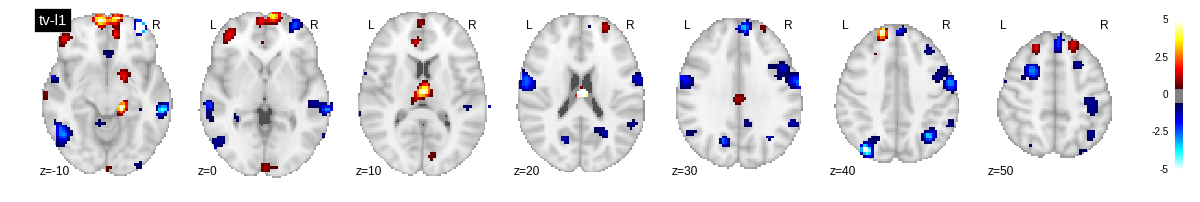

In [150]:
# %pylab inline
from nilearn.plotting import plot_stat_map
from nilearn.image import math_img,new_img_like
coef_img_=new_img_like(decoder.coef_img_,coef_img)

plot_stat_map(coef_img_, title="tv-l1", display_mode="z",cut_coords=range(-10,60,10),threshold=0.5,vmax=5)
# math_img("np.mean(img,axis=3)", img=coef_img).to_filename('FB+NFB-Performance-Classification.nii.gz')
coef_img_.to_filename('FB+NFB-Performance-Classification-1000-Bootstrap.nii.gz')

In [128]:
print 'Mean AUC: %0.2f std AUC: %0.2f' % (np.mean(auc),np.std(auc))

Mean AUC: 0.71 std AUC: 0.08


In [129]:
trials_preds=np.zeros((len(y),))
num_preds=np.zeros((len(y),))
for preds,indices in zip(total_preds,test_locations):
    trials_preds[indices]+=preds
    num_preds[indices]+=1.0

In [130]:
yVal=trials_preds/num_preds

In [153]:
print roc_auc_score(y,yVal)
print roc_auc_score(y,yVal>=0.5)

0.880514705882
0.785845588235


In [132]:
import pickle

pickle.dump( {'auc':auc,'yVal':yVal,'trials_preds':trials_preds,'num_preds':num_preds,'total_preds':total_preds,'test_locations':test_locations,'true_y':y}, open( "FB+NFB-Performance-Group.p", "wb" ) )

(array([   1.,    3.,   10.,   22.,   36.,   52.,   83.,  152.,  111.,
         172.,  160.,   89.,   76.,   24.,    9.]),
 array([ 0.45036765,  0.4810049 ,  0.51164216,  0.54227941,  0.57291667,
         0.60355392,  0.63419118,  0.66482843,  0.69546569,  0.72610294,
         0.7567402 ,  0.78737745,  0.81801471,  0.84865196,  0.87928922,
         0.90992647]),
 <a list of 15 Patch objects>)

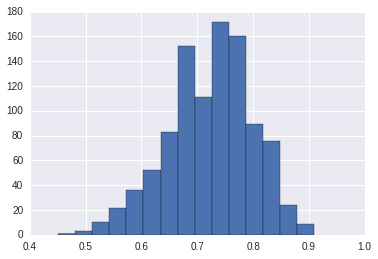

In [152]:
plt.hist(auc,15)

In [158]:
1-float(sum(np.array(auc)>.5))/1000

0.0040000000000000036

In [161]:
decoder_perm = SpaceNetClassifier(mask=mask_filename, penalty="tv-l1",cv=3,l1_ratios=0.5,screening_percentile=20,
                            alphas=[.1,.05,.01],  # prefer large alphas
                            memory="nilearn_cache",n_jobs=15,verbose=1)

y_perm=np.array(y).copy()
shuffle(y_perm)

# preds,coef_img=leaveOneGroupOutCV_nilearn(decoder,clean_imgs,np.array(y),subjGroup)
sss = StratifiedShuffleSplit(n_splits=1000, test_size=0.5, random_state=42)
auc_perm=[]
split=0
for train_index, test_index in sss.split(np.array(y), y_perm):
    shuffle(y_perm)
    decoder_perm.fit(image.index_img(clean_imgs,train_index), y_perm[train_index])
    preds_tmp=decoder.predict(image.index_img(clean_imgs,test_index))
    auc_perm.append(roc_auc_score(y_perm[test_index],preds_tmp))
    split+=1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


Time Elapsed: 71.6385 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b18250>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da9a290>, <nibabel.nifti1.Nifti1Image object at 0x7fba45a7bcd0>, { 'detr

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a7bcd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.5469 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60ffd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.2323 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d289f90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.2069 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.6375 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   36.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.000312, ...,  0.      ]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 39.2043 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da079590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.9193 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   34.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 37.4765 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.1993 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86dd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -9.310223e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.0913 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   39.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba04277d50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 42.6253 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7110d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.995 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.1321 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a70950>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d3d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.9827 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86190>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.7989 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d60fb90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.0267 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 86.1567 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d598850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.5365 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.042703]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d990>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.5538 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba482773d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[-0.000161, ...,  0.      ]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a708d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.7587 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 79.555 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   36.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -9.524856e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60ffd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 38.9872 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8129d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.212 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.5min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   2.445208e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 91.5512 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de15690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71d10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.6699 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9b54510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fe10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.4099 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d7a37ad0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.8121 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba704a2450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.1021 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74d490>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f2d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.9148 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595a50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.6334 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d257050>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -6.778738e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.1242 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 48.0091 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.342 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74d3d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.8796 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277090>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da2aa10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.6888 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8a4290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.884 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d60fd10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  6.224921e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.1409 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bc110>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.6372 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74dc50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.4017 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bcd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b80d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 79.8787 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d257050>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   26.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  5.892962e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 29.4329 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.7787 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.7523 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   2.298226e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.5227 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   40.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fd10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 43.133 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d9d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.2785 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a70e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 82.995 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86190>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df704910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.7805 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9ed2690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.379664e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.6844 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8090>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  4.647096e-06, ...,  -9.467826e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.3566 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9b54510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4312d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.6308 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99e03a310>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -4.330894e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de15690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.9529 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a70790>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 85.8199 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df98f810>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.9989 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.7085 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.8802 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 84.1795 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c39d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71d10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.3936 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74de90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.3681 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.2495 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ...,  0.041713]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d598490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.1155 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595a50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dd21750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.6977 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   40.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -3.049667e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 43.2197 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d17ddd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.9183 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   39.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 42.0517 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  4.085885e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8129d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.1096 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d9d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.8423 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df841a90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   32.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.591068e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8c50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 35.1321 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7fbd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   56.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df809910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.9944 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -4.524709e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.9885 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.6719 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba40abd690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.496 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d551510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.1423 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7a37ad0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  4.708406e-06, ...,  -5.397196e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.6992 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd21750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.000666]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.7042 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df755850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 81.9783 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a70210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.8591 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d86c450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   33.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 36.1034 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c39d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 85.9639 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.2746 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -4.042534e-05, ...,  -2.791361e-02]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.7976 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df823610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4312d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.7249 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -1.481202e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.4541 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99db64350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -3.948542e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df704910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.1423 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a3b390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  8.075252e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 84.1035 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -9.159006e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.6475 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -5.771483e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fe10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.4957 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.6928 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.609 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  7.169687e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.3264 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da82690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.627211e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 81.2586 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.3117 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d598850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.0089 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.281738e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.4545 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba3baba750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8c50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.4201 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -1.204286e-05, ...,   9.896704e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fd10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.4021 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2aa10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.018779]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 81.4976 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277810>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 79.5414 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df746b50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.8696 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74d390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   37.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71d10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 40.094 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   7.009414e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.6838 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d985a290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  4.583591e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.7241 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df98f810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.6536 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d60f2d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -1.255809e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.9112 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.3095 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fd10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.645 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a70950>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.871 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.7664 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da82690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.6776 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.8102 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df704910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b867d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.5062 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  3.705423e-06, ...,  -1.081604e-04]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.7419 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.7881 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8129d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  4.413434e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e69390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.8124 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -3.197539e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d990>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.869 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.6616 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.2462 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8e1a10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df77a9d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.1755 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -3.707040e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.2028 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.8851 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   39.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d9d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 41.6517 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.7214 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595a50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70c90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.8299 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8e1a10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.1138 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.809 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d598850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   36.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.360480e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 39.4415 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba482773d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.1881 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba482773d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.0562 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd76690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -3.566179e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.4421 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   42.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.9964 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.108402e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de15690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.027 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.206 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  5.683863e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e69390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.1229 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -2.246384e-07, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da2aa10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.3669 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.184 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd76690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70050>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.0147 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   56.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.6582 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   38.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 40.946 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86cd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f2d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.407 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74dc50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.5248 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7b80d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.0966 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8088d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.6922 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -1.488700e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.8448 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df841a90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d050>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.0242 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9b54510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.6278 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a70950>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.9468 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8129d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.235 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d289f90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d050>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.1985 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   38.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da9a290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 41.168 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a3b390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d050>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.0062 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df755850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -1.622935e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.3136 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d60fe10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.844032e-06, ...,  -6.334267e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.8009 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.8747 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df68350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   38.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 40.7474 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba3baba750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70e90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 79.9322 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.9723 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.5min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -5.703306e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 90.793 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99db64350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.8524 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74d9d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.1213 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   38.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 41.363 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   56.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71d10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 59.1794 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -4.051154e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.9565 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a70450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df767d50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.8591 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd76690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.5min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 90.2711 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  3.407050e-05, ...,  -2.025349e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fd10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 82.4363 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74d650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -4.957677e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.2661 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808950>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b80d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.5413 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df98f810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.6245 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d86c450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.0561 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d990>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 85.6523 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.2766 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 45.7091 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74dc50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.5471 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.110120e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.237 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.5694 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d331d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.3318 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.2796 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.774 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da82690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.280036e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70e90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.4955 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2aa10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8eedd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.4586 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -9.002763e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.0995 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df823cd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.5851 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.9219 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b865d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -5.263912e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba482773d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.3562 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d60f2d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.5min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  3.076294e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 94.7113 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8a4290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.8647 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba40abd690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dd76690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.4578 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d331d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -6.995188e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.1428 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fe10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.742 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bcb50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.9771 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df82fc10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de15690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.5897 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86cd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.1249 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.2395 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   6.390939e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.5778 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa94d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.4983 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de15690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.1767 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431190>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.1675 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.0789 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba04277d50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70050>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.9011 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa94d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  4.308548e-06, ...,  -7.568778e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e69390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.809 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71d10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -4.661225e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8d10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.5666 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba482773d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8c50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.892 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86d50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   7.958090e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 81.5109 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d257050>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -2.144400e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.9784 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   2.473128e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.7732 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277810>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.5627 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.975098e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.388 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -2.570790e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f2d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.1134 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.9673 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.1819 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.4145 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d289f90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a7bcd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.0946 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df823cd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.3156 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba0429d450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.5622 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9f3c590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.5454 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa94d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.8946 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba04277d50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.3475 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.6116 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.000241]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.4196 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d289f90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   8.989191e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.2762 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba0429d450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.8884 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8eedd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.379769e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.8792 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bc110>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.4698 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86d50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.7247 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   9.351922e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.9846 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8b0dd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b865d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.8489 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.2118 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051bcb50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.516 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.8692 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.327437e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.0841 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   56.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 59.422 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.0515 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  2.811507e-06, ...,  -2.116558e-02]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.5633 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a3b390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.     , ..., -0.03206]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.2195 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9c2e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -2.646301e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df823cd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.4726 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277710>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  3.076953e-07, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8eedd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.1639 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8d10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.4672 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98d75d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   31.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.219636e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 34.6503 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2aa10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da159d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.6955 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.5857 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8129d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.002984]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 85.7461 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a3b390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -3.719494e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8c50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.5429 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   8.489820e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fd10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.121 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.1731 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71d10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.5158 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8088d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -1.465003e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d8088d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.8873 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.8054 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bcd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74de90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.7512 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d598490>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.795 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba042ac890>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   40.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a708d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 42.8744 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fa50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.1638 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.0442 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   34.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 36.7624 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   7.781874e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da2aa10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.4496 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d551510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.9806 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.1374 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d331d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -1.141425e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99db64350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.5046 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8088d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.2072 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.4427 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.9407 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8530d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.6104 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba482773d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba482773d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.9691 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df746b50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595a50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.7638 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df704910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 79.4297 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df20c90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.8681 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431150>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b865d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.1621 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d257050>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.2773 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da9a290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71d10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.3827 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   40.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 43.6924 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9f3c590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   36.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 39.4677 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd21750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  7.418753e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 85.6318 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d341a10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba40abd690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 79.0513 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.7687 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.0928 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.3014 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  9.362507e-06, ...,   3.384339e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.3614 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -9.973242e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86b50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.3929 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60ffd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.9469 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277810>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.4529 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98425d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.9604 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b18250>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c2e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.4143 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd76690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 86.9268 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df704910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -5.882916e-07, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.7466 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   4.954712e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.748 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dfa1810>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.8344 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9ed2690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.3354 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c39d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.933 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df82fc10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fd10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.0901 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da159d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.8838 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   31.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[-0.000254, ...,  0.      ]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 33.8146 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba40abd690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.4362 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dd76690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.6403 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8190>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.7355 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -5.954542e-05, ...,  -2.475948e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fba482773d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.4251 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fb90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.5957 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bc110>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.1004 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   39.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 41.744 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.5692 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595a50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.899 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.0145 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df809210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.3946 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.0044 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9ed2690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b865d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.36 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d60f590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1s

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 81.3311 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74d050>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d8088d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.9263 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d289f90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -6.927120e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.0869 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d17ddd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.5131 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2aa10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.1242 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d341a10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ...,  0.002133]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.4791 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df746b50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.4071 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71d10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.3294 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d990>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.0439 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -7.401419e-08, ...,   8.321442e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de15690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 81.8964 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -5.734660e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2c39d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.6534 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.9986 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.7268 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da079590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.9625 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da82690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.4218 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7fbd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   40.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7ab2d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 43.3787 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da12ce50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4312d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.0763 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d341a10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86dd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.8718 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df704910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 59.8972 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df841a90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d8088d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.5727 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  3.622326e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.4086 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71d10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ...,  0.001529]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.2628 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.7656 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -2.017043e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 82.751 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431150>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.2157 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b867d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.5409 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  2.079877e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.5547 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de15690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70e90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.2374 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431150>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.332 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   5.759193e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 79.9296 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da12ce50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[-0.005328, ...,  0.      ]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.1418 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595a50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.2264 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7a37ad0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86cd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.8765 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba04385290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b80d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.4251 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.617323e-07, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 82.4906 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86dd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.9675 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   56.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.6343 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595a50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.011174]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.6643 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.279 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da82690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.5528 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99db64350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595a50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 84.7004 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74da50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.4221 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -7.056404e-07, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.3841 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8190>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.565 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -2.509040e-06, ...,  -1.190531e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.5714 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8129d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   42.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 45.6075 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da159d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d598490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.4183 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e69390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.0547 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba704a2450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.189693e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.4299 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70c90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.4611 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9b54510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.5313 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fe10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.8316 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.0348 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d598850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.3806 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7a37ad0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.0473 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bcb50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.1628 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d98d75d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.7782 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.3351 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74d490>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dd76690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.5077 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -2.410189e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.2727 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   9.131240e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.4252 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d331d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.1149 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7a37ad0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df704910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.9371 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d4312d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.4421 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df849c50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b80d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.22 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431a90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1s

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.000926, ...,  0.      ]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.226 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_an

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  2.987917e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.6886 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.055 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.6086 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7ab2d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fa50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.4977 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  4.816351e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.0257 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba3baba750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.9829 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d60fe10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.5512 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74d990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -8.099203e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.2926 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86b50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.5min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 91.9931 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a70050>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.1236 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.3374 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c39d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70e90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 84.6496 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c39d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8d10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.0941 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c39d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.8555 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c39d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   37.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fe10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 40.3755 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c39d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.9023 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c39d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -5.271076e-05, ...,  -5.956783e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.6184 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8088d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.0124 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba482773d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.0392 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   56.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -4.530697e-06, ...,   3.811809e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.6765 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99db64350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.0045 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4312d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.9145 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e69390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.4615 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 79.1598 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a3b390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.496 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.5764 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.1058 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fe10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.9488 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  5.730613e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba704a2450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.6126 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d598490>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.9536 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.8414 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -2.003045e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.6081 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70c90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.967 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d86c450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.8383 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d985a290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 83.5778 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.2256 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fd10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.8333 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.221 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99e03a310>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df98f810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.5368 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df849c50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ...,  0.009485]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.8668 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   36.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 38.9668 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd7fd10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.103364e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 84.2109 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da159d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.52 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1s

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74de90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 84.5884 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8129d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   9.542434e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.1848 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74de90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.0047 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9f3c590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.5512 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d257050>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d598490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.2785 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da12ce50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b80d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.8175 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431a90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.7047 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d60fe10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d990>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.8756 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7b80d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   38.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8129d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 41.347 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.5389 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98425d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da82690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.1937 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8088d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -1.730048e-05, ...,  -9.539589e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 45.999 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da12ce50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   36.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2c39d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 39.0573 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7fbd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c2e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 48.675 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74dc50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 86.0547 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a3b390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.8625 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74de90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.1311 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.5612 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.4882 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277710>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   40.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -2.716615e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 43.4297 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8e1a10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   5.114652e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.8693 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b867d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.5284 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d60fb90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -6.870093e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.0393 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d4312d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.9675 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a70450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.8928 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e69390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.4295 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.4633 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74d990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74de90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.1273 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.1945 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a14a50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -1.416018e-02, ...,   7.629920e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fba704a2450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.4407 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74dc50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   31.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595a50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 34.4099 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.0957 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9da00a590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 82.3067 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.666 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8129d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df704910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.5257 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da079590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8e1a10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.7326 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.0243 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8088d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -2.706246e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.2057 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d289f90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d985a290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.6167 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.3176 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d598850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   40.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 42.7873 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.3618 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.794890e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.2663 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d331d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.6min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   8.958520e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 97.0859 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bc110>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  7.469862e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.9658 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df77a9d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fa50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.779 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dad1550>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.9093 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dd21750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.9122 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -1.840760e-05, ...,   1.239952e-04]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.4843 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d303110>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.0419 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df823cd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70050>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.0791 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bc110>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.485165e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b867d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.1721 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df704910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.8558 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a14a50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba04277d50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.1135 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da8cfcd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595a50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 83.7836 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431150>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b867d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.3723 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da82690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -2.648369e-06, ...,  -1.938831e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.75 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fa50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.1912 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8129d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.5289 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.5min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e69390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 94.772 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808950>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.5min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -3.679692e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 95.4738 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df82fc10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a708d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 79.3274 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d598490>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74de90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.7504 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d75eed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d050>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.442 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d60f450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d9ed2690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.6622 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df823cd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.7735 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74da50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.5164 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9959190>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 59.8727 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.7342 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d598490>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  9.679574e-07, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 79.8291 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277710>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d990>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.1139 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.4548 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277090>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.774 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98d75d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.5421 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba042ac890>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.035311]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.1734 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 43.847 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d341a10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 83.9651 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d3d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.7898 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595a50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.7688 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   30.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 33.4548 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dad1550>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.8183 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da82690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.9226 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d60f590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.2001 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051bcb50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.0681 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   56.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fa50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 59.5614 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.244 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.5864 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.181393e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.7395 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba04385290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 79.3787 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa94d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 82.6424 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.6053 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 85.9077 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df823610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70050>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.5337 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d75eed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.5909 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d8088d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.0447 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   39.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.600951e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 42.3067 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da12ce50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.302916e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.1773 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.9682 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.1949 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba04277d50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   3.429865e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.7123 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8c50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 59.8811 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.00059, ...,  0.     ]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.6723 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da82690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 81.2151 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df767d50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df809910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.632 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.249168e-05, ...,  -1.650319e-02]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.4055 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df809210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.6485 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dad1550>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.2719 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74da50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.0858 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277810>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df809910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.4489 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.0141 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bcd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70c90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.1617 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.6247 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d60f590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.7674 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  6.016741e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.5679 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d985a290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.7363 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba042ac890>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.9383 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9b54510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -8.603781e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b867d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.6411 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   3.808668e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df823610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.8173 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.7318 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7ba4510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -8.718329e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.7946 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8d10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   37.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  7.290737e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 40.3607 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa94d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.674634e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.0349 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   30.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86b50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 33.4648 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.6352 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df823610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   6.700146e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.5772 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a70a90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da9a290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.1664 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df823cd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.2103 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74dc50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.6711 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.1123 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba3baba750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.4829 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba7717f6d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.3086 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277710>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.5861 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.0815 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.000159]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.8395 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df823cd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.5796 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.5827 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.469747e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fba3baba750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.7641 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7abac50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 81.0842 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9ced610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -1.375371e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.088 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.945 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86d50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.882 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -2.657727e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86cd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.2004 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.0945 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99db64350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d598490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.4955 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4312d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.1353 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -3.012296e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 81.4694 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d9a14a50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.6413 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   60.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a708d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.6928 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.25 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7ab2d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0s

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.1426 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da82690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   42.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[-0.000101, ...,  0.      ]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8c50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 45.1703 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.7812 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.2001 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.8008 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d75eed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.2487 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8129d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.1248 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 79.1921 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -1.285407e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.9403 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.7878 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8c50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.0634 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da82690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4312d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.7498 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   5.552157e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.8896 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   34.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 37.0467 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d75eed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.3517 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d4312d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 79.819 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a70790>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.1883 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595a50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.0195 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.765 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.3353 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   39.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 41.6925 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da00a590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.2352 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a3b390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.3515 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba3baba750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.9037 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de15690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 84.2459 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dad1550>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.4665 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -1.732972e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 85.3764 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa94d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.5478 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.7755 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.5943 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa94d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 48.1188 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d289f90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d9d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.7145 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da12ce50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4312d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.7897 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a70790>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.5591 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b867d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.698 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d75eed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70050>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.2065 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86d50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.030442, ...,  0.      ]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.3978 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bcd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -5.722152e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d990>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.9846 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a14a50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.5607 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.1021 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7ab2d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70050>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.0867 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.467944e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 87.9338 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9ed2690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d3d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.2622 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.0135 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a14a50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86d50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.486 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.2

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.5007 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431a90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.5009 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba482773d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -2.176694e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d98425d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.6366 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df704910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.8967 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d4312d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.4009 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df809910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.9725 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bc110>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595a50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.3367 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431a90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.8029 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd76690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -1.540352e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.185 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d8088d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.5434 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[-0.006916, ...,  0.      ]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.4574 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.8628 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd21750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -2.132447e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df767d50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.9616 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a14a50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.002816]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.9462 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.036754e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74da50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.2682 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.1071 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df767d50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74dc50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.9033 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d598490>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -1.364986e-04, ...,  -1.150127e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.1251 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df823610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  7.497682e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.1211 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d257050>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.3802 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df746b50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da2aa10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.2381 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a70790>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.0785 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d86c450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.311 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.9597 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.8956 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fb90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.2843 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da04950>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d9d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.2005 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba704a2450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  4.322512e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 85.724 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df79fc10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 82.4624 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.403212e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d98425d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.1343 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.5143 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bcd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.8373 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.4516 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bcb50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.9915 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da159d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.0341 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808950>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[-0.000104, ...,  0.      ]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d7a37ad0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.4732 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da9a290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d598490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.761 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd21750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7e90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.0383 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8c50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.9591 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.039 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99db64350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.0522 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a70e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -5.361459e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.8434 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ...,  0.000397]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.9408 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277810>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86b50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.6068 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.5019 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431a90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -2.067838e-06, ...,   2.233940e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.7957 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba704a2450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.3709 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.1135 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74de90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.1245 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.952 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8b0dd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  3.314571e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d17ddd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.2113 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da82690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da159d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.9033 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.3429 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df79fc10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.0762 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd21750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.5017 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   40.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99db64350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 43.4589 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.8214 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277090>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -2.004895e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.8579 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bc110>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b80d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.2244 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.000746]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 82.1293 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 48.3342 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.9849 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba04385290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da9a290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 81.256 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98425d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da04950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.1135 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bcb50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba04385290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.8222 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dd21750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 88.4904 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4312d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.9255 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.3214 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.2402 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70c90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.7041 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  2.269359e-07, ...,  -2.056428e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.645 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df823cd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.3814 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70c90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.3483 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd21750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   37.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 40.5396 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba042ac890>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   35.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 38.5918 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   36.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df68350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 39.253 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.3013 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df841a90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.6628 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba482773d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.4104 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.6549 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba704a2450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   33.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 35.9589 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  4.268339e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.1661 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  4.561233e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.5666 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8129d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d9f3c590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.6021 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431190>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99df070d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.5537 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  2.001779e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.3166 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.6521 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 43.8507 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8a4290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a708d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.4297 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   38.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 41.6431 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df68350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.13 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2aa10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1s

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ...,  0.001706]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.2957 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2aa10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba4d289f90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.3706 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8530d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  3.488809e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8c50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.2112 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da159d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba042ac890>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.1829 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.0041 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ...,  0.057609]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.3443 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a70450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.0043 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.242039e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.3009 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.7955 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7ba4510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.    , ..., -0.0007]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.9864 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_m

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70050>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.6312 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -3.574448e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fba3baba750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.0156 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.6801 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa94d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   2.457862e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.0746 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df75ee90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.0034 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d598850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.3769 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da82690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.9545 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a3b390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba40abd690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.3513 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   6.864643e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.7657 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df823cd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8eedd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.5413 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7ab2d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.511345e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.2502 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.8652 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8129d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.8497 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d17ddd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  4.384810e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.6266 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99e03a310>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d9d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.5669 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431790>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  3.135660e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.2125 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -3.480777e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.2241 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.001 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 87.5811 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.1957 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.0773 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de15690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 82.8099 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7ba4510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.9332 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.1357 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.7215 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99de15690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d050>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 48.3274 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba7717f6d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dd21750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.7759 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df823610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   36.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99de15690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 39.6421 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   4.605278e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b865d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.3128 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -6.382515e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.5909 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba704a2450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.9098 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df841a90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.426115e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.9396 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7a37ad0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.8884 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8530d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.6215 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.003456]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df823610>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.0005 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da04950>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.8906 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.2308 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8e1a10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  2.361550e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.4626 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd21750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba704a2450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 83.7612 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d598490>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   35.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.062494e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 37.731 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d60fe10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.025585]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.3734 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df746b50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.1058 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.261 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df82fc10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.8608 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99daa30d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.2325 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 89.4291 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d3d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.876 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.2

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 48.0636 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98d75d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.6252 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.7024 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a708d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.3403 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 89.3003 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.4032 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86d50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.9836 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -5.691063e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df809210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.2293 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98d75d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  4.891787e-08, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 83.7881 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df704910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.4396 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.0415 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74d990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.2682 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7e90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.9876 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99e03a310>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  3.970171e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da9a290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.5988 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d86c450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   38.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  7.398135e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86b50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 41.0988 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8129d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.1755 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   37.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 40.7501 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -8.192495e-07, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.0175 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.5min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 94.5433 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   56.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dad1550>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 59.3887 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.5146 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7abac50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -8.484498e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 81.1331 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df75ee90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99db64350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.0282 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d303110>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.2786 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da159d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.9443 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.9789 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277710>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.022488]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.4759 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8129d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.0104 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bc110>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.3954 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.6864 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da079590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 84.3278 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dad1550>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -2.548645e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.1424 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d985a290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.7045 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431a90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.1689 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d60f590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.0268 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -6.880806e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.4413 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.7081 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   6.261645e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.7573 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9ed2690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.3407 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.4563 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df823610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.073591e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.6363 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd76690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   56.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -4.378381e-05, ...,  -4.017309e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.6821 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d60fd10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.87 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1s

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4312d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.1288 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d86c450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.309820e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fa50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.2833 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98d75d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fb90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.6627 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d598490>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.4114 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.0306 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba482773d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.1346 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.2298 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.5261 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.9384 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   56.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 59.5575 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2a4d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.4879 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -3.293834e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.5081 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 48.2268 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9b54510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df77a9d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.5267 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d17ddd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.4232 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bc110>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.7619 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8b0dd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   34.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 37.374 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da159d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.4742 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a3b390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.8232 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa94d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 82.0911 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba0429d450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.054040e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.1969 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d985a290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.618563e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.3219 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.7358 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bcb50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.839381e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b867d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.7047 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8d10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -2.059311e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa94d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.5161 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9da079590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.0246 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.5401 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.8482 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86cd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.158 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.2755 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd7fd10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  7.611697e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 87.2379 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d289f90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -8.890551e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.8668 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8b0dd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.7075 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.4538 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.2056 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7ba4510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.2403 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277710>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.4668 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8088d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.0317 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b867d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.1196 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8b0dd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.640643e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.3644 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d598490>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -1.057665e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.7337 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98425d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   56.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b865d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 59.6287 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74de90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -2.176502e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9da12ce50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.0702 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8d10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.9786 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.469 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a3b390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a06d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.3453 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2aa10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -2.298959e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.1908 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 83.8441 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  3.284682e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df77a9d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.4866 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7fbd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.1704 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df790850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.3604 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d985a290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.6541 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a7fbd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.7887 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   36.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 39.5225 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a14a50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86b50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.9362 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8eedd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   39.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 41.9971 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.5096 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df823cd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -5.094900e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 86.3984 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   38.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 41.0876 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df841a90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7e90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.7801 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -6.168270e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 86.4842 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d802350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.1728 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.4266 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bcb50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60fd10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 48.1708 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba40abd690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   42.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.9427 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.6753 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da12ce50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba40abd690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.5016 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a3b390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df77a9d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.5868 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da04950>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.6371 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a70450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   39.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 42.3336 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98d75d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.6255 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   46.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da82690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.1895 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bcd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70490>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.0066 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d257050>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dd76690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 45.9775 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -3.167939e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.1483 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7ab2d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 48.4054 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 88.3696 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df704910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.488 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dfa1810>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.4761 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d75eed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.4521 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8190>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   4.120035e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.688 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d60f450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
_________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431790>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.4723 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  5.574834e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.0628 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7fbd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   50.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da2aa10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.8738 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df755850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba482773d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.5789 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.443911e-03, ...,   8.255425e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 70.5965 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8a4290>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.1692 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bcd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 81.2487 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -5.343131e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dfa1810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.4613 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.000102]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.3292 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809210>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 81.5139 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.0464 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.6s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.4289 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.4min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  1.204498e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 85.4388 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b80d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 59.8462 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98425d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  3.563754e-05, ...,   2.937695e-07]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.7472 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   49.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60ffd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 52.7369 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 49.8897 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99df68350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.8254 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df809910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d9959190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.6914 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74da50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.9477 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  3.271006e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.3749 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a3b390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.1421 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99e03a310>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.6613 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   5.262643e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8150>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.6688 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df8129d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 69.1209 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -4.885151e-05, ...,   2.163535e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.5425 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da159d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 82.4307 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277810>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.2631 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9c2e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8c50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 60.248 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9a14a50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.0

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70c90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 82.879 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df98f810>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.160573e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595a50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.4288 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8a4290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.1392 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b80d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.4176 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d75eed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -9.159410e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f2d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.4735 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431190>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   36.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 39.6248 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa9390>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   57.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 59.9708 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.2684 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b865d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.6627 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99db64350>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9da00a590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.6904 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa94d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.7088 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98425d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.1296 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da590d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   56.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 59.1892 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277810>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.0918 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df809210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.0891 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d598850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   4.640377e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.1708 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9da00a590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.693193e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595850>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.1706 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da04950>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74da50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.9063 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   42.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 45.4334 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  5.088387e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8c50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 82.3208 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60ffd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.9471 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da159d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.2851 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df823610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.963 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd21750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d9d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 79.8098 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   52.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.001121, ...,  0.      ]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d7abac50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 55.6229 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.5min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 90.5107 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d8026d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  5.293174e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.8897 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7110d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  2.354662e-05, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.5018 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d9b8e90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.011889, ...,  0.      ]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.0897 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2aa10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.6255 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d341a10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   53.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d431a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 56.5315 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595a50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.1388 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d7abac50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8090>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.0821 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 76.478 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d985a290>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70e90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.8578 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df823cd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df812990>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.9802 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277090>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   3.386687e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d7ba4510>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.8712 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71f50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.      , ..., -0.000113]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 68.7296 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45b86850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_a

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d9c2e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.9506 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bcd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -6.606838e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.0901 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d17ddd0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   43.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b867d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.2472 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da159d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99da82690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.5061 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba45a7bf50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,  -7.706342e-06]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e69390>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 53.8014 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d303110>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.9553 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da159d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   58.9s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d98425d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 61.546 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d98d75d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71d10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.089 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba7717f6d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 80.3439 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da15650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.5206 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4312d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.284 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9d9ed2690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.9447 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.3206 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   59.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70210>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.064 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74d3d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   48.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -4.315247e-07, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 51.6353 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb97d7d5910>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9d9aa94d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.9482 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da2aa10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.5689 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d303110>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70e90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.6384 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7abe90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99dd76690>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 73.6155 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99da590d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051bc110>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.4952 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba40abd690>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 79.7468 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df8124d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   51.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d595b90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 54.2514 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba4d289f90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9bab90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 79.355 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df767d50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   37.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f8190>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 40.0615 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277710>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d808950>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.708 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7ab2d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   34.2s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 37.0942 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba7717f6d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 43.7894 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d74da50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba48277590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.4851 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7044d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   44.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71d10>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 46.871 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.2

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.8553 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba043c2610>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.3min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d050>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 78.0129 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277810>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   41.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7f7590>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 44.5756 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d595d90>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 63.8346 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bcb50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   54.5s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70c90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 57.2251 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e71d10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   39.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b80d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 41.9779 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d2c39d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 74.2204 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5f10>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  3.549196e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45b86b50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 77.9202 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5e50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   55.3s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f750>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 58.2243 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d4312d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8d90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 62.9302 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df9ba510>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   47.8s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 50.67 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277810>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1s

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  0.000000e+00, ...,   1.092021e-05]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df704910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 71.4526 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99dd21750>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  3.384227e-07, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9da12ce50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 64.2698 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df767d50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.1s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a7fbd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 47.9229 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba051bcb50>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0ed0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.944 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2c3250>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.1

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d74d9d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.0677 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99daa30d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba051a0e50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.3409 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb999e69650>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fba043c2bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.9969 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d2d5ed0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0.     , ..., -0.00012]]), <nibabel.nifti1.Nifti1Image object at 0x7fba45a70a90>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 66.2573 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d808950>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df7b8bd0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 72.3007 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df790850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   45.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -2.616652e-06, ...,  -2.215606e-04]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df9baf50>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 48.5159 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d3f81d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.1min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb999e71910>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 67.2257 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba48277590>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.0min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ -2.012157e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb9df77a9d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 65.1388 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d598850>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   39.7s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[  2.562499e-06, ...,   0.000000e+00]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d4315d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 42.4523 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb9df7ab2d0>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
________________________________________________

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:  1.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d8088d0>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 75.6997 seconds, 1 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fba0429d450>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning:

Function center_data is deprecated; center_data was deprecated in version 0.18 and will be removed in 0.20. Use utilities in preprocessing.data instead

[Parallel(n_jobs=15)]: Done   1 out of   1 | elapsed:   38.4s finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[ 0., ...,  0.]]), <nibabel.nifti1.Nifti1Image object at 0x7fb99d60f450>)
___________________________________________________________unmask - 0.1s, 0.0min
Time Elapsed: 41.1562 seconds, 0 minutes.
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fb99d431190>, <nibabel.nifti1.Nifti1Image object at 0x7fb99da1ca50>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=0, memory=Memory(cachedir='nilearn_cache/joblib'))
__________________________________________________filter_and_mask - 1.

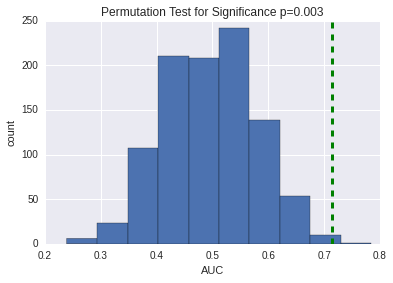

In [167]:
plt.hist(auc_perm)
ylim = plt.ylim()
# BUG: vlines(..., linestyle='--') fails on older versions of matplotlib
#plt.vlines(score, ylim[0], ylim[1], linestyle='--',
#          color='g', linewidth=3, label='Classification Score'
#          ' (pvalue %s)' % pvalue)
#plt.vlines(1.0 / n_classes, ylim[0], ylim[1], linestyle='--',
#          color='k', linewidth=3, label='Luck')
plt.plot(2 * [np.mean(auc)], ylim, '--g', linewidth=3)
plt.title('Permutation Test for Significance p=0.003')
plt.xlabel('AUC')
plt.ylabel('count')
plt.savefig('%s/Classification_perms.jpg' % CCD_packages.saveFigureLocation,dpi=300)

In [163]:
1-float(sum(auc_perm<np.mean(auc)))/1000

0.0030000000000000027